# Machine Learning - Random Forest

In this section, Random Forest is used to forecast the apple prices.

## ⚠️ Disclaimer

> This project is created **for educational and research purposes only**.  
> It does **not** constitute investment advice or financial recommendations.  
> All data is sourced from [Yahoo Finance](https://finance.yahoo.com/) using the `yfinance` Python package.  
> This project is **not affiliated with, endorsed by, or officially connected to Apple Inc.** in any way.

# Preprocessing and augmentation

In [3]:
#Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Retrieving 5 years of historical Apple stock data
apple_df = yf.Ticker("AAPL").history(period="5y", interval="1d")
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 00:00:00-04:00,60.849350,62.009355,60.524157,61.837051,167976400,0.0,0.0
2020-03-31 00:00:00-04:00,62.028751,63.700805,61.155105,61.710838,197002000,0.0,0.0
2020-04-01 00:00:00-04:00,59.820385,60.359133,58.031842,58.463810,176218400,0.0,0.0
2020-04-02 00:00:00-04:00,58.325473,59.492759,57.490657,59.439369,165934000,0.0,0.0
2020-04-03 00:00:00-04:00,58.922472,59.626239,57.993010,58.585148,129880000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,221.000000,221.479996,218.580002,220.729996,44299500,0.0,0.0
2025-03-25 00:00:00-04:00,220.770004,224.100006,220.080002,223.750000,34493600,0.0,0.0
2025-03-26 00:00:00-04:00,223.509995,225.020004,220.470001,221.529999,34532700,0.0,0.0


In [5]:
"""
Similar steps like ML01. Please check ML01_Decision_Tree file to preprocessing part.
"""

#Dividing date to year, month and day columns, and resetting index
apple_df.index = pd.to_datetime(apple_df.index)
apple_df["Day_of_Week"] = apple_df.index.dayofweek
apple_df["Year"] = apple_df.index.year
apple_df["Month"] = apple_df.index.month
apple_df["Day"] = apple_df.index.day
apple_df = apple_df.reset_index(drop=True)
#Shifting High and Low
apple_df["Previous_High"] = apple_df["High"].shift(1)
apple_df["Previous_Low"] = apple_df["Low"].shift(1)
apple_df["Previous_Volume"] = apple_df["Volume"].shift(1)
apple_df.drop(["High", "Low","Volume"], axis=1, inplace=True)
#Creating lags for Close price
for lag in range(1, 62):
    apple_df[f"Close_lag_{lag}"] = apple_df["Close"].shift(lag)
#Getting to moving averages of previous days
apple_df["Previous_MA_5"] = apple_df["Close"].shift(1).rolling(window=5).mean()
apple_df["Previous_MA_20"] = apple_df["Close"].shift(1).rolling(window=20).mean()
apple_df["Previous_MA_ratio"] = apple_df["Previous_MA_5"] / apple_df["Previous_MA_20"]
apple_df.drop(columns=["Dividends","Stock Splits"],inplace=True)
apple_df.dropna(inplace=True)

# Train and Test Set

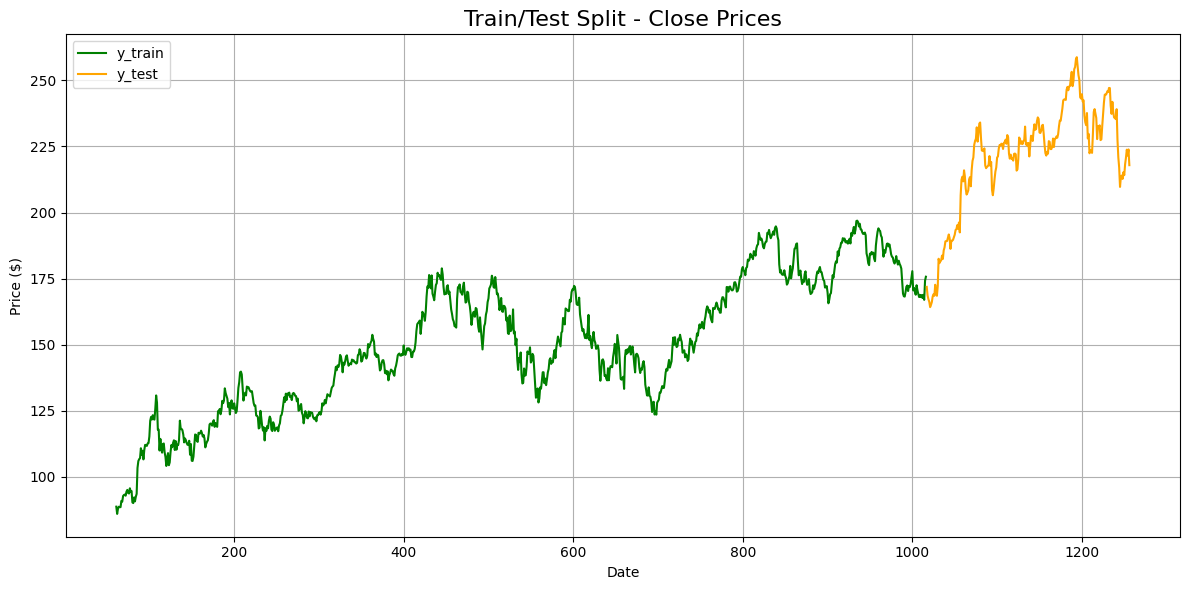

In [6]:
X = apple_df.drop(columns=["Close"])
y = apple_df["Close"]
train_size = int(len(X) * 0.8) # %80 train %20 test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='y_train', color='green')
plt.plot(y_test.index, y_test, label='y_test', color='orange')
plt.title("Train/Test Split - Close Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest

# First Try

In this part, I compared decision tree fail test with random forest. Random Forest predictions are better than Decision Tree. However, there is still range problem.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [14]:
#Parameters for gridsearch
param_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": [None, "sqrt", "log2"]
}

In [15]:
rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

In [16]:
#Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [18]:
y_pred_decision = best_model.predict(X_test)
y_test = y_test.to_numpy()
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
print(f"R^2 is {r2_dec} \n RMSE is {rmse_dec} \n MAPE is {mape_dec}")

R^2 is -1.6689802962531606 
 RMSE is 33.91310477246105 
 MAPE is 0.12850685114930244


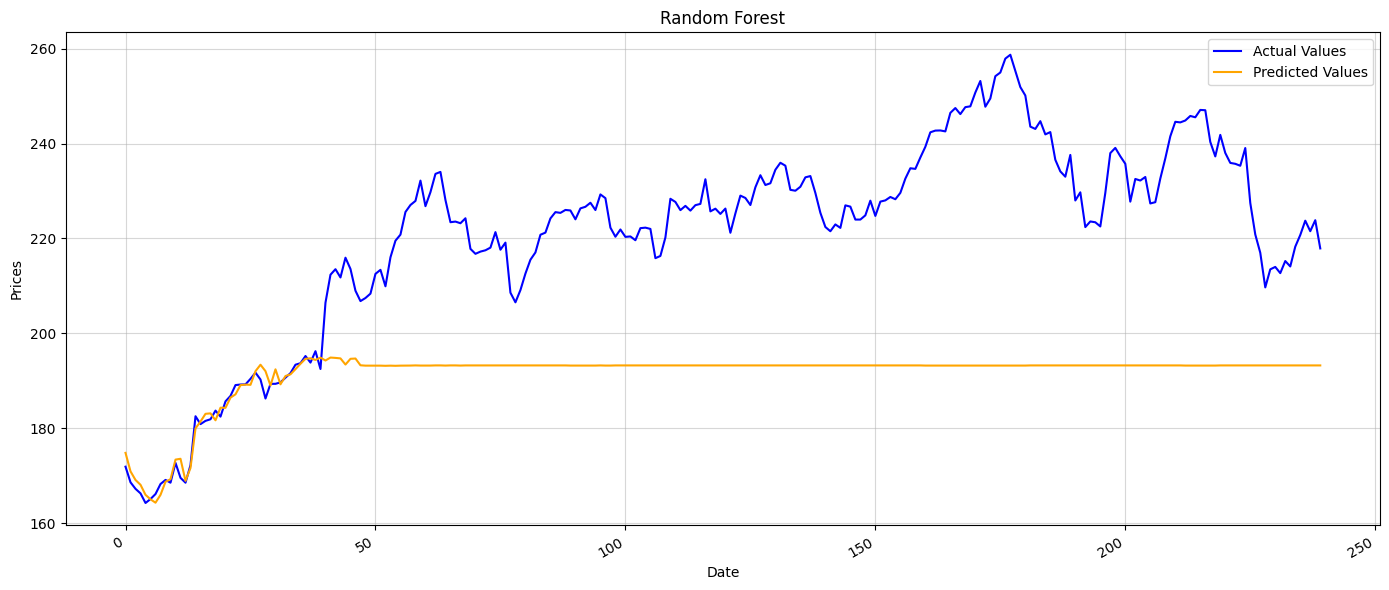

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_decision, label="Predicted Values", color="orange")
plt.title("Random Forest")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
print("Training set 'Close' range:", y_train.min(), "to", y_train.max())
print("Test set 'Close' range:", y_test.min(), "to", y_test.max())

Training set 'Close' range: 86.0509033203125 to 196.9276580810547
Test set 'Close' range: 164.2245635986328 to 258.7355041503906


## %90 Train, %10 Test

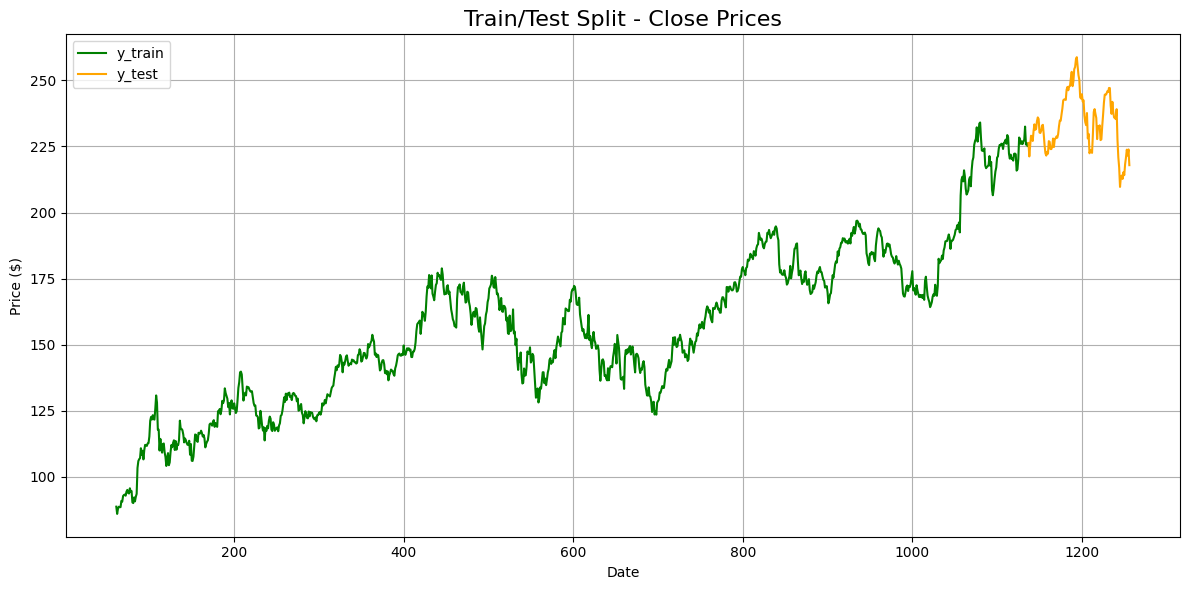

In [22]:
X = apple_df.drop(columns=["Close"])
y = apple_df["Close"]
train_size = int(len(X) * 0.9) # %90 train %10 test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='y_train', color='green')
plt.plot(y_test.index, y_test, label='y_test', color='orange')
plt.title("Train/Test Split - Close Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [24]:
y_pred_decision = best_model.predict(X_test)
y_test = y_test.to_numpy()
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
print(f"R^2 is {r2_dec} \n RMSE is {rmse_dec} \n MAPE is {mape_dec}")

R^2 is -0.3307100195221624 
 RMSE is 12.311240280901817 
 MAPE is 0.03799828284402171


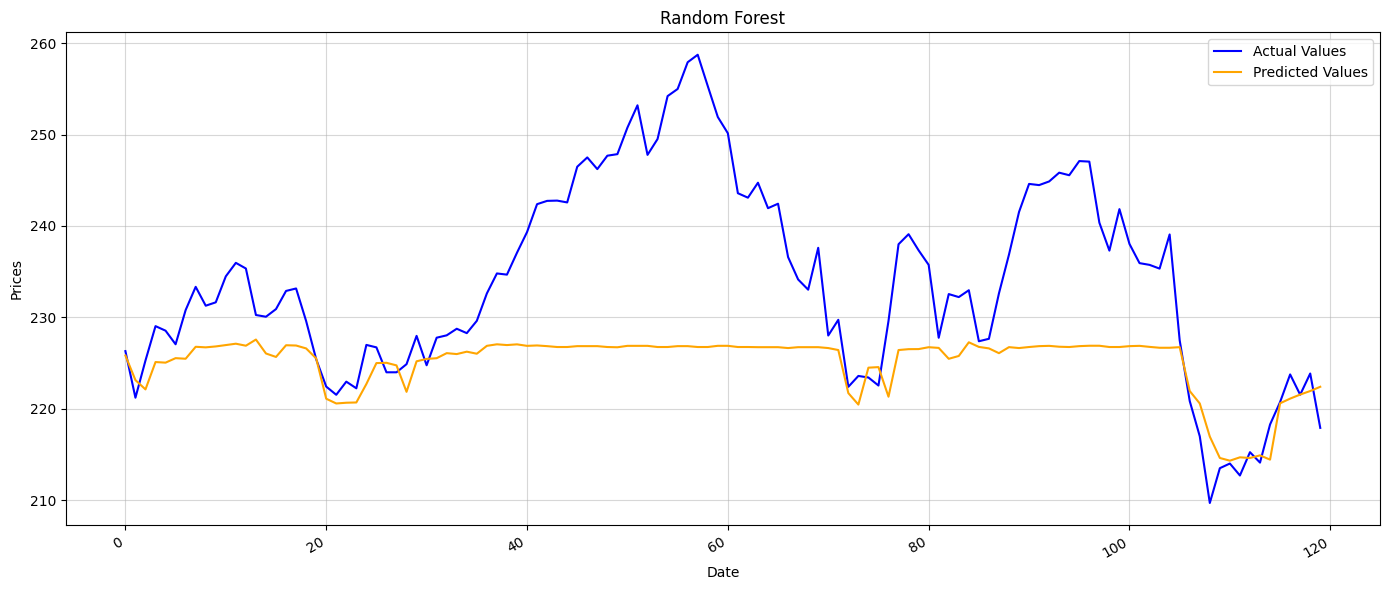

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_decision, label="Predicted Values", color="orange")
plt.title("Random Forest")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

## %97 Train, %3 Test

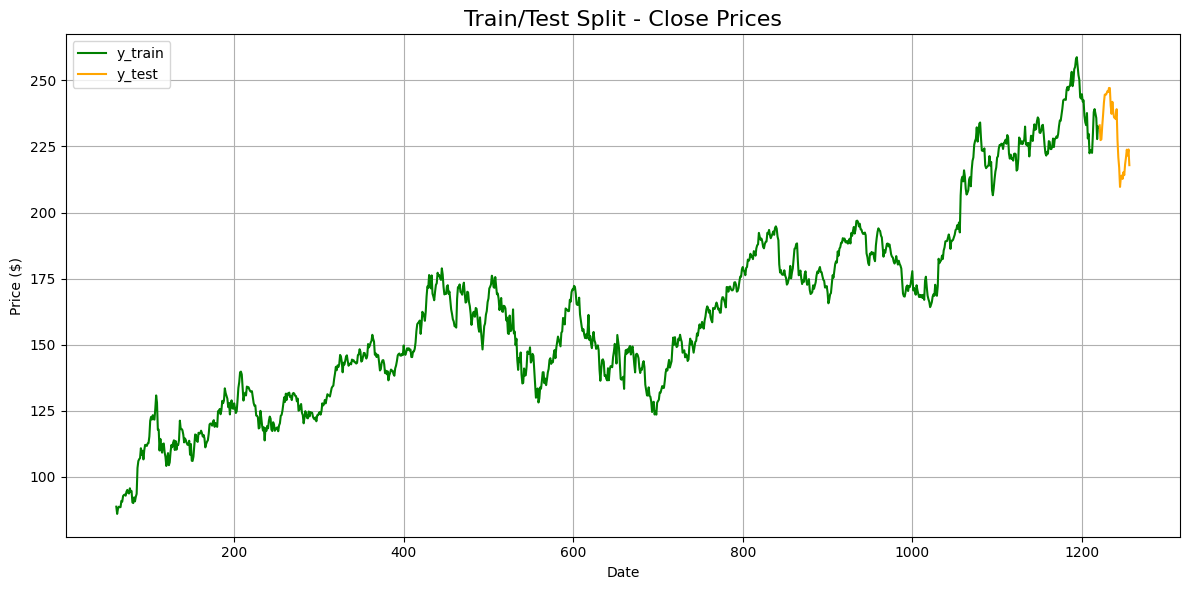

In [26]:
#Increaing train size 90 to 97
train_size = int(len(X) * 0.97) # %97 train %3 test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='y_train', color='green')
plt.plot(y_test.index, y_test, label='y_test', color='orange')
plt.title("Train/Test Split - Close Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
#Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [31]:
y_pred_decision = best_model.predict(X_test)
y_test = y_test.to_numpy()
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
print(f"R^2 is {r2_dec} \n RMSE is {rmse_dec} \n MAPE is {mape_dec}")

R^2 is 0.8674355674336899 
 RMSE is 4.272302693029153 
 MAPE is 0.014095745513241414


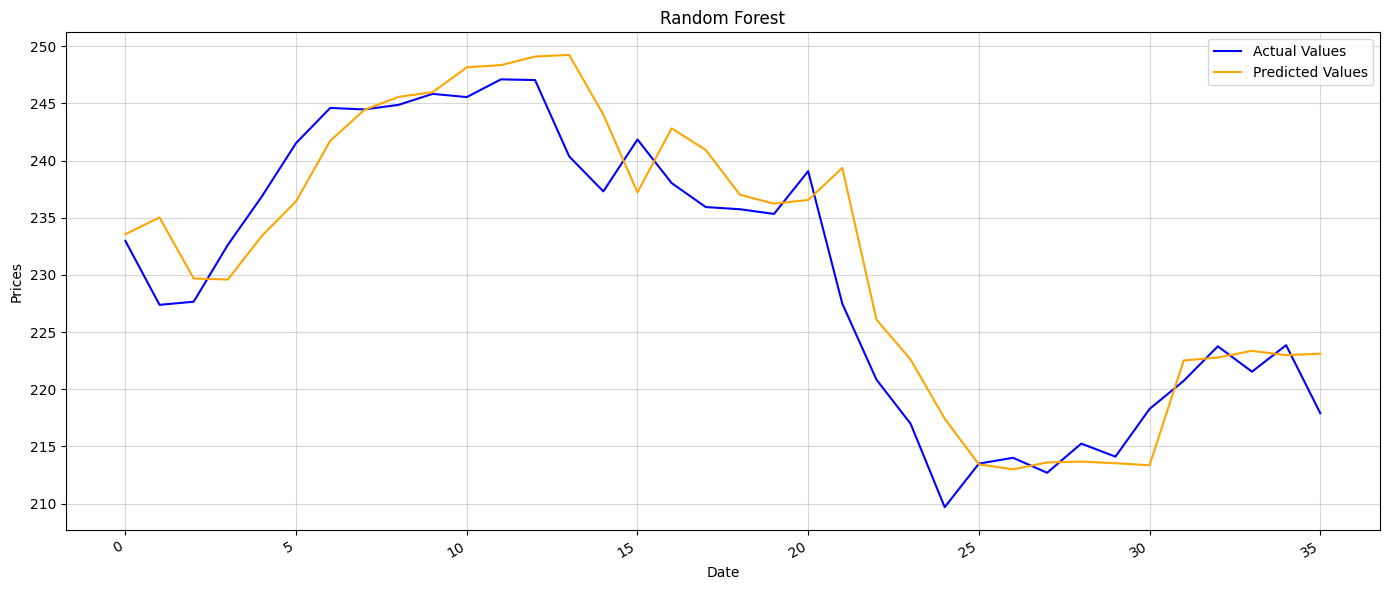

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_decision, label="Predicted Values", color="orange")
plt.title("Random Forest")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()